# Intuition for Overfitting

## Background

I was working on a classification project and getting great test results. But as you can imagine (since I'm writing this article), the results were too good to be true. I was overfitting my data. I want to share the intuition behind overfitting and how to avoid it with this toy example.

## The task

I have a dataset of ~200 emails, and I want to predict whether they are spam or not. 

In [12]:
import pandas as pd

df = pd.read_csv('./spam_ham_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


Let's clean up the text and lemmatize it.

In [13]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean(text):
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    return clean_text

df['clean_text'] = df['text'].apply(clean)

[nltk_data] Downloading package punkt to /Users/bkitano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bkitano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bkitano/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load the tf-idf vectorizer

We need to turn the emails into vectors of numbers. We'll use the tf-idf vectorizer from scikit-learn. 

Train and fit tf-idf on the dataset to create embeddings

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['clean_text'].apply(lambda x: ' '.join(x)))
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y)

Fit logistic regression to classify based on lemmatized words, show that it works well

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))

print(cross_val_score(lr, X_train, y_train, cv=5))

print(classification_report(lr.predict(X_test), y_test))

0.9956162970603404
[0.99097938 0.98453608 0.9871134  0.98064516 0.98193548]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       885
           1       0.98      0.95      0.97       408

    accuracy                           0.98      1293
   macro avg       0.98      0.97      0.98      1293
weighted avg       0.98      0.98      0.98      1293



Dive in on how: the logistic regression is learning - learning a score for each word.

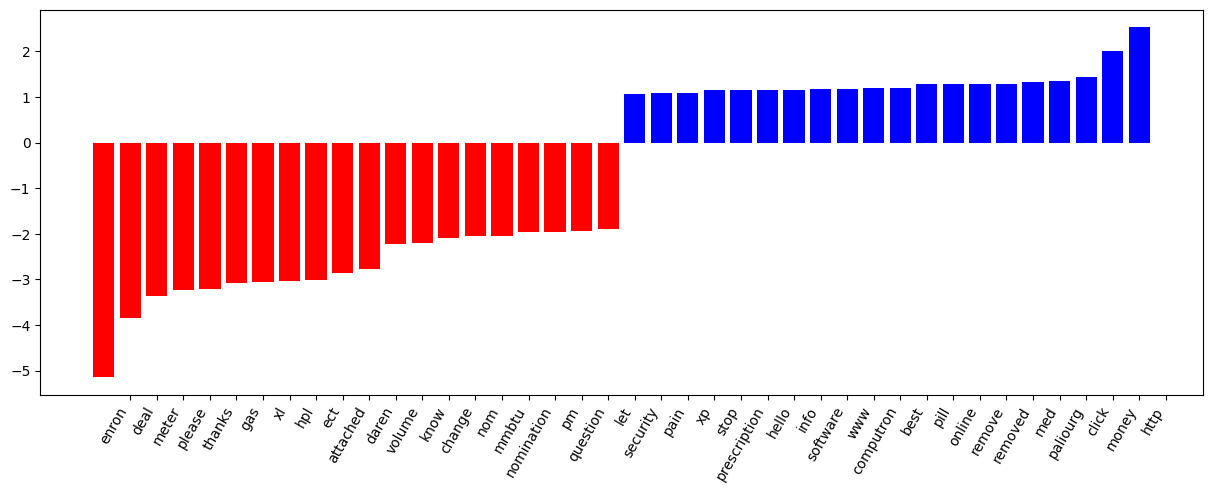

In [18]:
# get the weights of each word within the linear regression
import numpy as np
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]

    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

# get feature names from tfidf
feature_names = tfidf.get_feature_names_out()
plot_coefficients(lr, feature_names)


Load the SimpleNet, train it on the dataset, show that it works poorly

Show how the SimpleNet is actually an ensemble of independent logistic regressions, each learning a score for each word. The output node is yet another logistic regression, learning a score for each group of words.

Show that if we investigate a single first-layer neuron, we can actually map it to a single email in our dataset - indicating severe overfitting.

Explore whether adding regularization helps. It does, but not enough.
- dropout
- `l2` regularization

Conclusions: neural nets are not magic, they are just a bunch of logistic regressions. They are not a good fit for this problem, because they are too powerful and overfit.